In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from collections import Counter

# === Step 1: Load and preprocess data ===
df = pd.read_csv("MAINDiagnostics.csv")
df = df.drop(columns=["IDFILENAME", "FileName", "Beat"])
df["Gender"] = df["Gender"].map({"MALE": 1, "FEMALE": 0})

normal_group = ["SR", "SB", "ST", "SI", "SAAWR"]
arrhythmia_group = ["AFIB", "AF", "SVT", "AT", "AVNRT", "AVRT"]
df["Rhythm_Binary"] = df["Rhythm"].apply(lambda x: 0 if x in normal_group else (1 if x in arrhythmia_group else np.nan))
df = df.dropna(subset=["Rhythm_Binary"])

X = df.drop(columns=["Rhythm", "Rhythm_Binary"], errors='ignore').values
y = df["Rhythm_Binary"].astype(int).values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === SSO-inspired oversampling for class 1 ===
X_min = X_scaled[y == 1]
X_maj = X_scaled[y == 0]
n_to_generate = len(X_maj) - len(X_min)

def sso_augment(X, n_samples):
    n_features = X.shape[1]
    augmented = []
    for _ in range(n_samples):
        i, j = np.random.choice(len(X), 2, replace=False)
        alpha = np.random.uniform(-1, 1, n_features)
        sample = X[i] + alpha * (X[j] - X[i])
        augmented.append(sample)
    return np.array(augmented)

X_syn = sso_augment(X_min, n_to_generate)
y_syn = np.ones(n_to_generate, dtype=int)

X_bal = np.vstack([X_scaled, X_syn])
y_bal = np.concatenate([y, y_syn])

# === Train/test split ===
X_train, X_val, y_train, y_val = train_test_split(X_bal, y_bal, test_size=0.2, random_state=42, stratify=y_bal)
input_dim = X_train.shape[1]

# === Step 2: Define fuzzy membership layer ===
class FuzzyLayer(tf.keras.layers.Layer):
    def __init__(self, in_features, num_memberships):
        super(FuzzyLayer, self).__init__()
        self.in_features = in_features
        self.num_memberships = num_memberships
        self.mu = self.add_weight("mu", shape=[num_memberships, in_features], initializer="random_normal", trainable=True)
        self.sigma = self.add_weight("sigma", shape=[num_memberships, in_features], initializer="ones", trainable=True)

    def call(self, inputs):
        x = tf.expand_dims(inputs, axis=1)
        mu = tf.expand_dims(self.mu, axis=0)
        sigma = tf.expand_dims(self.sigma, axis=0)
        return tf.exp(-tf.square((x - mu) / sigma))

# === Step 3: Build model ===
def build_model(mu_init, sigma_init):
    fuzzy = FuzzyLayer(input_dim, num_memberships=3)
    fuzzy.mu.assign(tf.convert_to_tensor(mu_init, dtype=tf.float32))
    fuzzy.sigma.assign(tf.convert_to_tensor(sigma_init, dtype=tf.float32))
    
    inputs = tf.keras.Input(shape=(input_dim,))
    fuzzy_out = fuzzy(inputs)
    flat = tf.keras.layers.Flatten()(fuzzy_out)
    dense1 = tf.keras.layers.Dense(128, activation='relu')(flat)
    drop = tf.keras.layers.Dropout(0.2)(dense1)
    dense2 = tf.keras.layers.Dense(64, activation='relu')(drop)
    output = tf.keras.layers.Dense(2, activation='softmax')(dense2)
    
    model = tf.keras.Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# === Step 4: WHHO optimization ===
def fitness_function(position):
    mu = position[:len(position)//2].reshape(3, input_dim)
    sigma = np.abs(position[len(position)//2:].reshape(3, input_dim)) + 1e-2
    model = build_model(mu, sigma)
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
    y_pred = np.argmax(model.predict(X_val), axis=1)
    return 1 - accuracy_score(y_val, y_pred)

def whho_optimize(dim, n_agents=5, max_iter=5):
    pop = np.random.uniform(-1, 1, (n_agents, dim))
    fitness = np.array([fitness_function(ind) for ind in pop])
    best_idx = np.argmin(fitness)
    best = pop[best_idx]

    for _ in range(max_iter):
        for i in range(n_agents):
            r = np.random.rand()
            pop[i] = pop[i] + r * (best - pop[i])
            fitness[i] = fitness_function(pop[i])
        best_idx = np.argmin(fitness)
        best = pop[best_idx]
    return best

dim = 2 * 3 * input_dim
opt_vector = whho_optimize(dim)
mu_opt = opt_vector[:len(opt_vector)//2].reshape(3, input_dim)
sigma_opt = np.abs(opt_vector[len(opt_vector)//2:].reshape(3, input_dim)) + 1e-2

# === Step 5: Train final model ===
final_model = build_model(mu_opt, sigma_opt)
final_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=32, verbose=1)

# === Step 6: Evaluate ===
y_pred_final = np.argmax(final_model.predict(X_val), axis=1)
print(classification_report(y_val, y_pred_final, target_names=["Normal", "Arrhythmia"]))







92/92 [==============================] - 0s 548us/step
Epoch 1/30
365/365 [==============================] - 1s 1ms/step - loss: 0.3822 - accuracy: 0.8261 - val_loss: 0.2660 - val_accuracy: 0.8933
Epoch 2/30
365/365 [==============================] - 0s 990us/step - loss: 0.2519 - accuracy: 0.8970 - val_loss: 0.2065 - val_accuracy: 0.9156
Epoch 3/30
365/365 [==============================] - 0s 947us/step - loss: 0.2091 - accuracy: 0.9194 - val_loss: 0.1840 - val_accuracy: 0.9249
Epoch 4/30
365/365 [==============================] - 0s 997us/step - loss: 0.1849 - accuracy: 0.9308 - val_loss: 0.1678 - val_accuracy: 0.9335
Epoch 5/30
365/365 [==============================] - 0s 964us/step - loss: 0.1689 - accuracy: 0.9373 - val_loss: 0.1612 - val_accuracy: 0.9393
Epoch 6/30
365/365 [==============================] - 0s 1ms/step - loss: 0.1570 - accuracy: 0.9399 - val_loss: 0.1691 - val_accuracy: 0.9355
Epoch 7/30
365/365 [==============================] - 0s 1ms/step - loss: 0.1437

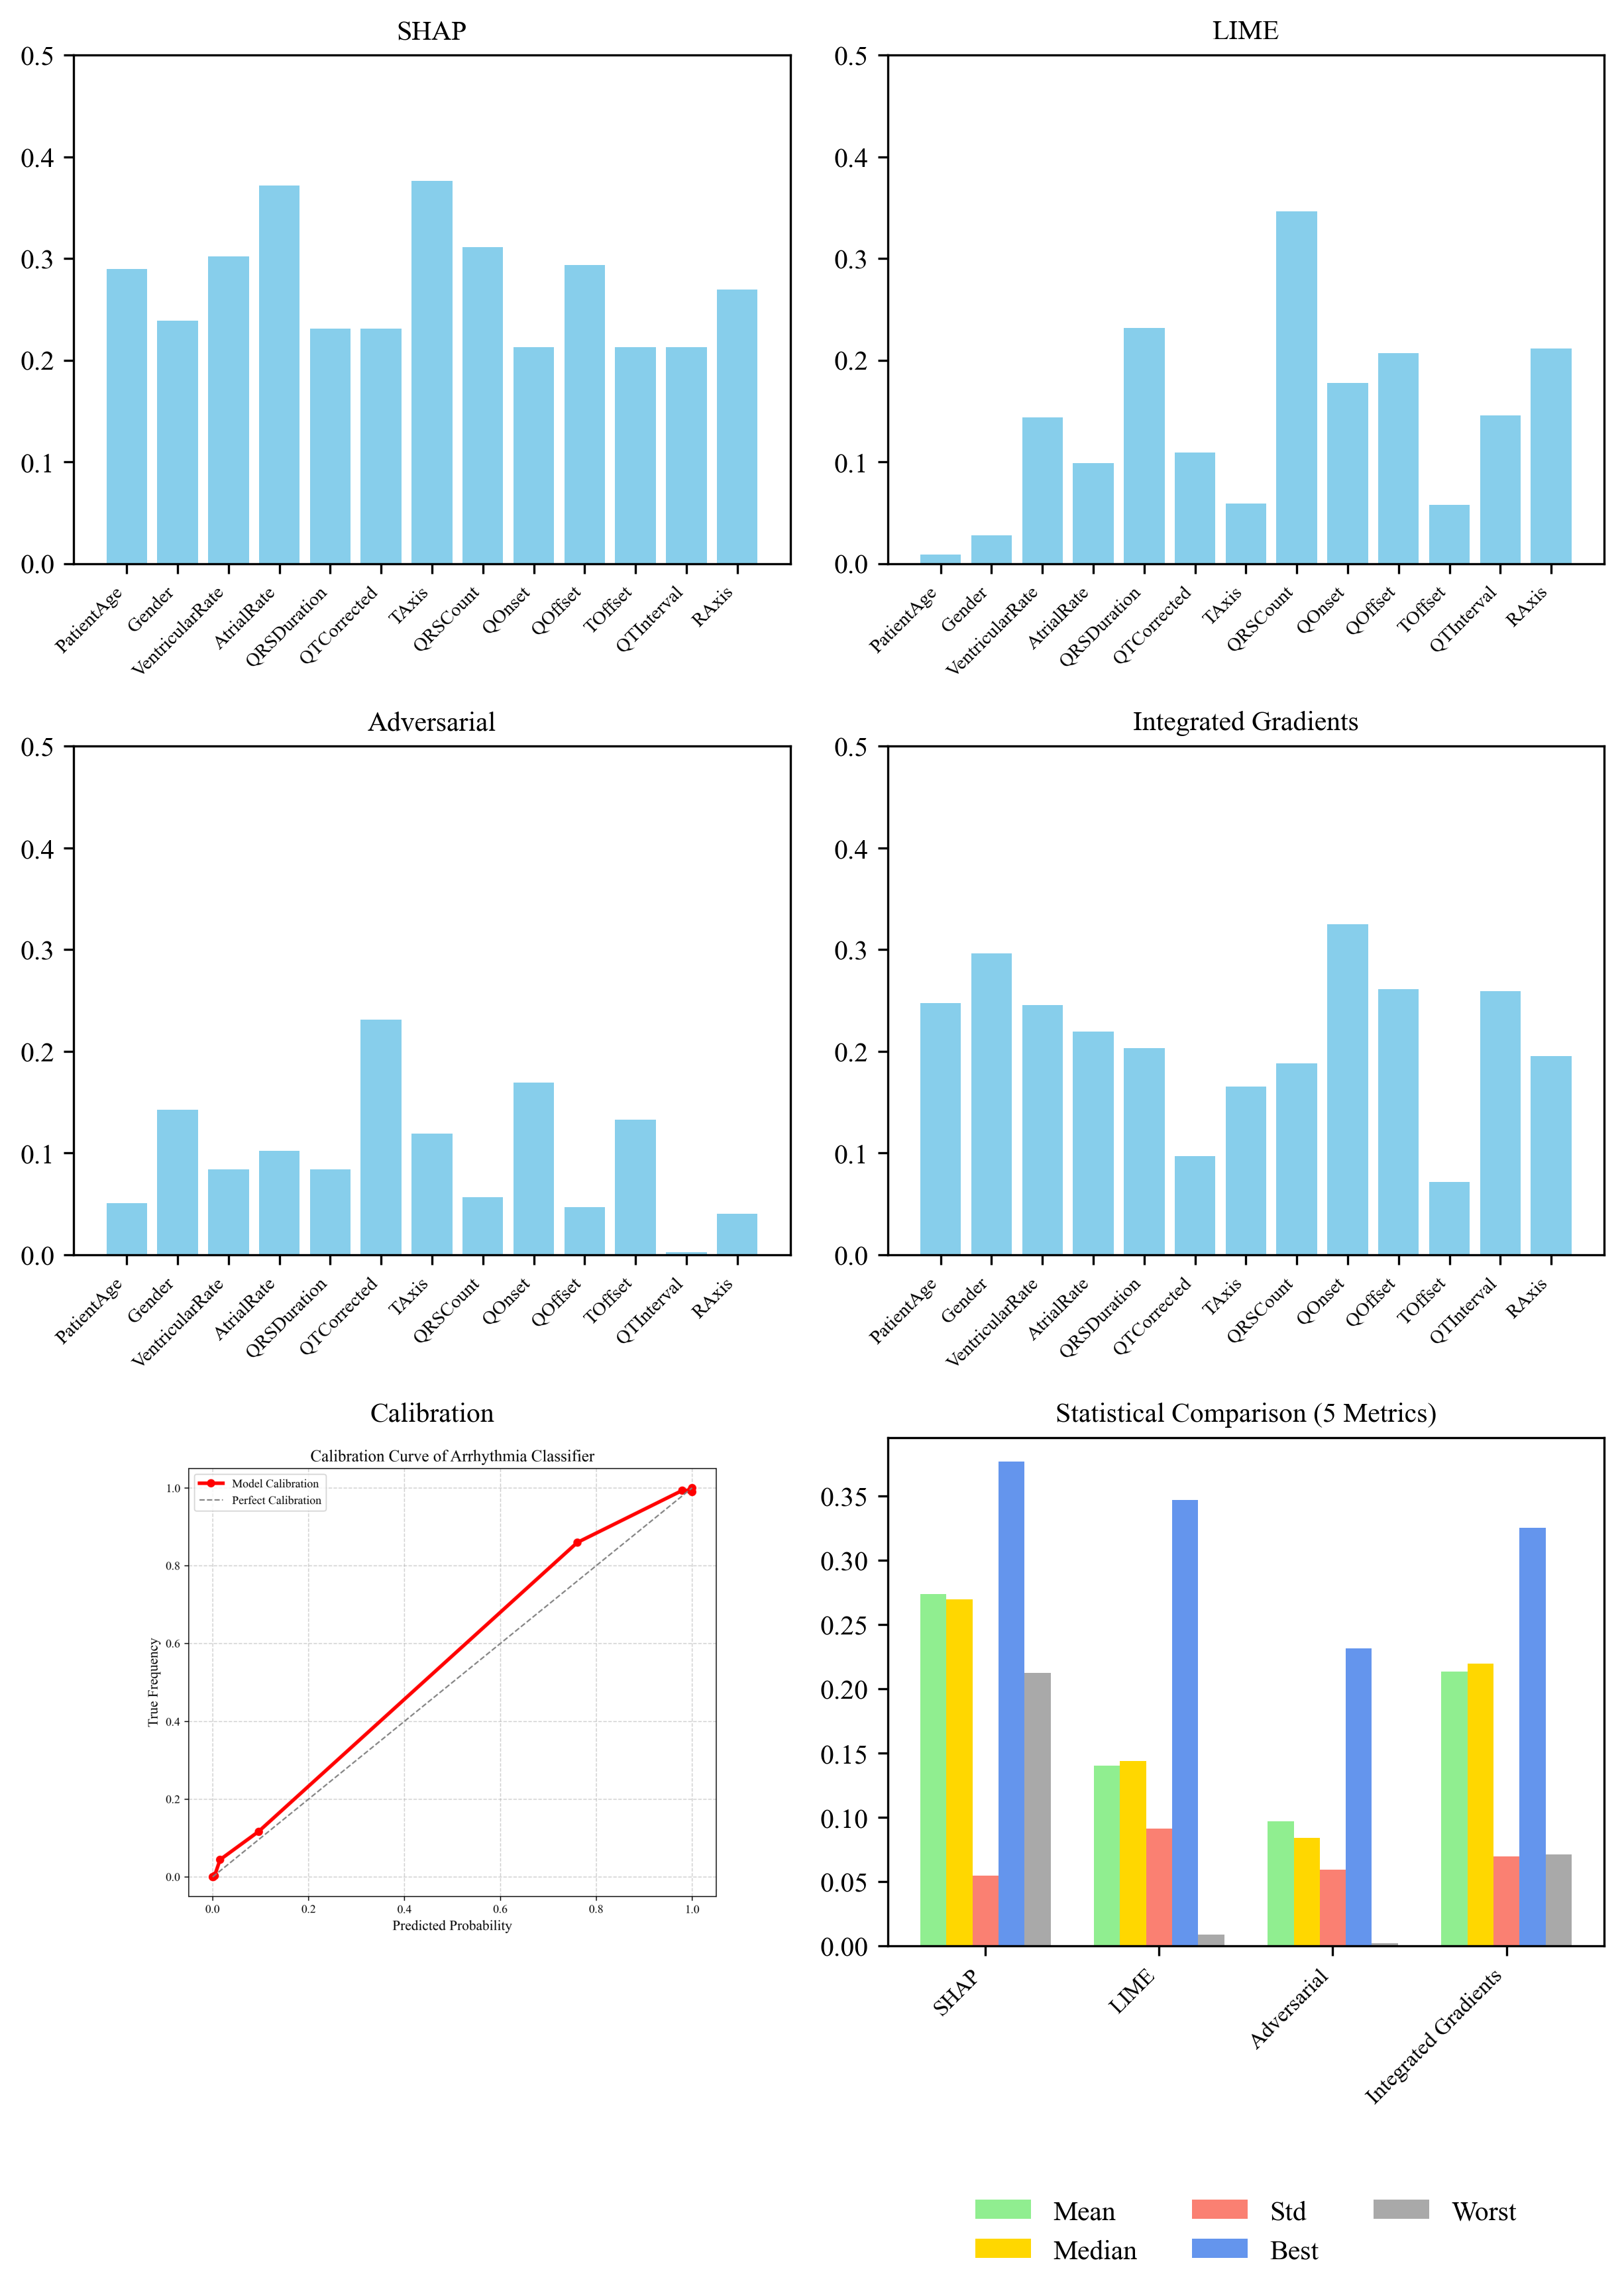

In [2]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import matplotlib

# Set font to Times New Roman globally
matplotlib.rcParams['font.family'] = 'Times New Roman'

# Feature names (from dataset)
feature_names = [
    'PatientAge', 'Gender', 'VentricularRate', 'AtrialRate', 'QRSDuration',
    'QTCorrected', 'TAxis', 'QRSCount', 'QOnset', 'QOffset', 'TOffset',
    'QTInterval', 'RAxis'
]

# Simulated interpretability values (replace with actual data)
np.random.seed(42)
shap_vals = np.random.normal(0.25, 0.08, len(feature_names))
lime_vals = np.random.normal(0.2, 0.1, len(feature_names))
adv_vals = np.random.normal(0.12, 0.06, len(feature_names))
ig_vals = np.random.normal(0.23, 0.09, len(feature_names))

methods_data = {
    "SHAP": shap_vals,
    "LIME": lime_vals,
    "Adversarial": adv_vals,
    "Integrated Gradients": ig_vals
}

# Statistics for each method
mean_vals = [np.mean(vals) for vals in methods_data.values()]
median_vals = [np.median(vals) for vals in methods_data.values()]
std_vals = [np.std(vals) for vals in methods_data.values()]
best_vals = [np.max(vals) for vals in methods_data.values()]
worst_vals = [np.min(vals) for vals in methods_data.values()]

# Create layout
fig = plt.figure(figsize=(8.27, 11.69), dpi=300)
gs = gridspec.GridSpec(3, 2, figure=fig)
axes = [fig.add_subplot(gs[i, j]) for i in range(3) for j in range(2)]

# Plot interpretability bar charts
for ax, (method, values) in zip(axes[:4], methods_data.items()):
    ax.bar(feature_names, values, color='skyblue')
    ax.set_title(method, fontsize=10)
    ax.set_xticks(range(len(feature_names)))
    ax.set_xticklabels(feature_names, rotation=45, ha='right', fontsize=7)
    ax.set_ylim(0, 0.5)

# Insert the calibration plot
from matplotlib.image import imread
calib_img = imread('calibration_curve_arrhythmia_final.png')
axes[4].imshow(calib_img)
axes[4].axis('off')
axes[4].set_title("Calibration", fontsize=10)

# Statistical comparison bar plot
ax_sum = axes[5]
x = np.arange(len(methods_data))
bar_width = 0.15

ax_sum.bar(x - 2 * bar_width, mean_vals, width=bar_width, label='Mean', color='lightgreen')
ax_sum.bar(x - bar_width, median_vals, width=bar_width, label='Median', color='gold')
ax_sum.bar(x, std_vals, width=bar_width, label='Std', color='salmon')
ax_sum.bar(x + bar_width, best_vals, width=bar_width, label='Best', color='cornflowerblue')
ax_sum.bar(x + 2 * bar_width, worst_vals, width=bar_width, label='Worst', color='darkgray')

ax_sum.set_xticks(x)
ax_sum.set_xticklabels(methods_data.keys(), rotation=45, ha='right', fontsize=8)
ax_sum.set_title("Statistical Comparison (5 Metrics)", fontsize=10)
ax_sum.legend(loc='upper center', bbox_to_anchor=(0.5, -0.45), ncol=3, frameon=False)

plt.tight_layout()
plt.savefig("explainability_comparison_with_real_calibration.png", dpi=300)
plt.show()
